In [77]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [78]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

(x_train[0].shape, y_train[0].shape)

((28, 28, 1), (10,))

In [80]:
save_path = "C:/Niranjan/Ashoka/Semester 8/Thesis/pretrained_models/adv"

In [82]:
path = save_path + "/mnist_cnn_original.h5"
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [87]:
path = f'{save_path}/mnist_cnn_trained.h5'
robust_classifier_model = load_model(path)
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False )

robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [102]:
path = f'{save_path}/mnist_cnn_random.h5'
random_classifier_model = load_model(path)
random_classifier = KerasClassifier(clip_values=(min_, max_), model=random_classifier_model, use_logits=False )

random_classifier_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [88]:
# define a function that returns all mnist images from a particular class
def get_images_of_class(x, y, class_n=0):
    # add x and y to a dataframe
    data_df = pd.DataFrame({'x': list(x), 'y': list(y)})

    # y is one hot encoded, convert it to a single number
    data_df['y'] = data_df['y'].apply(lambda x: np.argmax(x))

    # filter the dataframe to get only the rows where y is equal to class_n
    data_df = data_df[data_df['y'] == class_n]
    
    # return x and y columns as arrays
    return np.array(data_df['x'].tolist()), np.array(data_df['y'].tolist())
   

In [89]:
x,y = get_images_of_class(x_test, y_test, 0)
x.shape, y.shape

((980, 28, 28, 1), (980,))

In [90]:
# check accuracy on x
preds = np.argmax(classifier.predict(x), axis=1)
num_correct = np.sum(preds == y)

print("Accuracy on class 0: ", num_correct / len(y))

Accuracy on class 0:  0.9948979591836735


In [91]:
preds = np.argmax(robust_classifier.predict(x), axis=1)
num_correct = np.sum(preds == y)

print("Accuracy on class 0: ", num_correct / len(y))

Accuracy on class 0:  0.9948979591836735


In [96]:
attacker = FastGradientMethod(classifier, eps=0.4)
x_test_adv = attacker.generate(x, y)

# check accuracy on x_test_adv
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
num_correct = np.sum(preds == y)

print("Adv Accuracy on class 0: ", num_correct / len(y))

Adv Accuracy on class 0:  0.29081632653061223


In [97]:
attacker = FastGradientMethod(robust_classifier, eps=0.4)
x_test_adv = attacker.generate(x, y)

# check accuracy on x_test_adv
preds = np.argmax(robust_classifier.predict(x_test_adv), axis=1)
num_correct = np.sum(preds == y)

print("Adv Accuracy on class 0: ", num_correct / len(y))

Adv Accuracy on class 0:  0.7438775510204082


In [103]:
from keras.models import Model

def get_class_activations(x,y,model='robust'):
  
  assert model in ['robust', 'normal', "random"], "model should be either 'robust' or 'normal'"
  if model == 'robust':
    flatten_layer = Model(inputs=robust_classifier_model.input, outputs=robust_classifier_model.get_layer('flatten_1').output)
  elif model == 'normal':
    flatten_layer = Model(inputs=classifier_model.input, outputs=classifier_model.get_layer('flatten').output)
  elif model == 'random':
    flatten_layer = Model(inputs=random_classifier_model.input, outputs=random_classifier_model.get_layer('flatten_2').output)

  return flatten_layer.predict(x)

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [47]:
def estimate_dimensions_PCA(activations, threshold=0.95):
  pca = PCA()
  activations = StandardScaler().fit_transform(activations)
  pca.fit(activations)
  n_dimensions = np.argmax(np.cumsum(pca.explained_variance_ratio_) > threshold) + 1
  return n_dimensions

In [104]:
normal_CAM_dims = []
robust_CAM_dims = []
random_CAM_dims = []
normal_cAdv_acc = []
robust_cAdv_acc = []
random_cAdv_acc = []


for i in range(10):
  x, y = get_images_of_class(x_train, y_train, i)
  normal_acts = get_class_activations(x, y, model='normal')
  robust_acts = get_class_activations(x, y, model='robust')
  random_acts = get_class_activations(x, y, model='random')

  normal_CAM_dims.append(estimate_dimensions_PCA(normal_acts))
  robust_CAM_dims.append(estimate_dimensions_PCA(robust_acts))
  random_CAM_dims.append(estimate_dimensions_PCA(random_acts))


In [105]:
def get_classwise_adv_accuracy(classifier, x, y, eps=0.4):
  attacker = FastGradientMethod(classifier, eps=eps)
  x_adv = attacker.generate(x, y)
  preds = np.argmax(classifier.predict(x_adv), axis=1)
  num_correct = np.sum(preds == y)
  return num_correct / len(y)

In [107]:
for i in range(10):
  x, y = get_images_of_class(x_test, y_test, i)
  normal_cAdv_acc.append(get_classwise_adv_accuracy(classifier, x, y))
  robust_cAdv_acc.append(get_classwise_adv_accuracy(robust_classifier, x, y))
  random_cAdv_acc.append(get_classwise_adv_accuracy(random_classifier, x, y))

In [106]:
normal_CAM_dims, robust_CAM_dims, random_CAM_dims

([325, 197, 358, 372, 347, 351, 299, 306, 364, 305],
 [152, 97, 141, 157, 174, 142, 150, 131, 183, 157],
 [530, 296, 536, 574, 502, 533, 498, 444, 596, 507])

In [108]:
normal_cAdv_acc, robust_cAdv_acc, random_cAdv_acc

([0.29081632653061223,
  0.0,
  0.13178294573643412,
  0.01089108910891089,
  0.034623217922606926,
  0.005605381165919282,
  0.18684759916492694,
  0.0,
  0.11806981519507187,
  0.0019821605550049554],
 [0.7438775510204082,
  0.0,
  0.5523255813953488,
  0.22871287128712872,
  0.34623217922606925,
  0.0257847533632287,
  0.5104384133611691,
  0.0038910505836575876,
  0.7073921971252567,
  0.04360753221010902],
 [0.0,
  0.0052863436123348016,
  0.0,
  0.0,
  0.0,
  0.0,
  0.018789144050104383,
  0.0029182879377431907,
  0.0,
  0.01684836471754212])

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot accuracy against dimesnion

plot_df = pd.DataFrame({
    'normal_dim': normal_CAM_dims,
    'robust_dim': robust_CAM_dims,
    'random_dim': random_CAM_dims,
    'normal_adv_acc': normal_cAdv_acc,
    'robust_adv_acc': robust_cAdv_acc,
    'random_adv_acc': random_cAdv_acc
})
round_to_nearest_5 = lambda x: int(5 * round(x/5))
# multiply by 100
plot_df['normal_adv_acc'] = plot_df['normal_adv_acc'] * 100
plot_df['robust_adv_acc'] = plot_df['robust_adv_acc'] * 100
plot_df['random_adv_acc'] = plot_df['random_adv_acc'] * 100

# # round accs to nearest 5
# plot_df['normal_adv_acc'] = plot_df['normal_adv_acc'].apply(round_to_nearest_5)
# plot_df['robust_adv_acc'] = plot_df['robust_adv_acc'].apply(round_to_nearest_5)
# plot_df['random_adv_acc'] = plot_df['random_adv_acc'].apply(round_to_nearest_5)



<Figure size 1000x500 with 0 Axes>

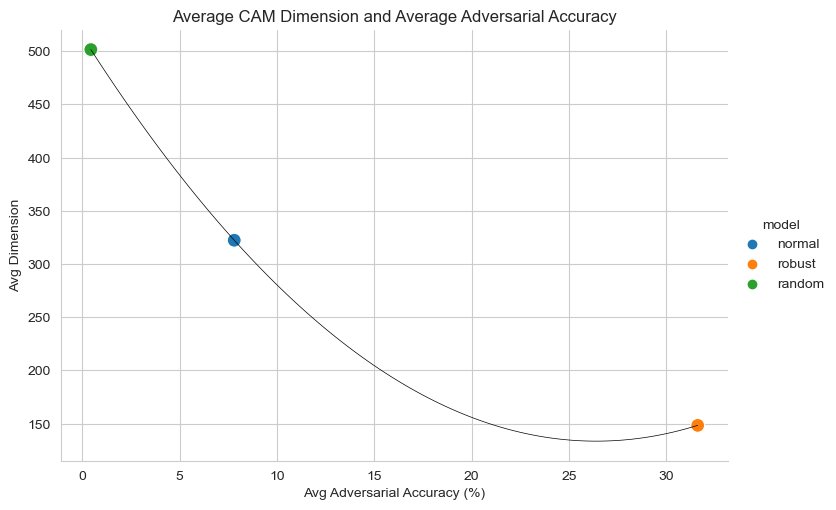

In [163]:



normal_df = plot_df[['normal_dim', 'normal_adv_acc']]
robust_df = plot_df[['robust_dim', 'robust_adv_acc']]
random_df = plot_df[['random_dim', 'random_adv_acc']]

avg_df = pd.DataFrame({'model': ['normal', 'robust', 'random'], 
                       'avg_dim': [normal_df['normal_dim'].mean(), robust_df['robust_dim'].mean(), random_df['random_dim'].mean()],
                       'avg_acc': [normal_df['normal_adv_acc'].mean(), robust_df['robust_adv_acc'].mean(), random_df['random_adv_acc'].mean()]
                       })

avg_df

# plot avg dim vs avg acc with avg dif
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
sns.relplot(y='avg_dim', x='avg_acc', data=avg_df, hue='model', s=100, kind='scatter', aspect=1.5)
# fit a reg plot of order 2 and find equation of the curve with lighter colour
sns.regplot(y='avg_dim', x='avg_acc', data=avg_df, order=2, scatter=False, ci=None, color='black', line_kws={'lw': 0.5})
plt.title('Average CAM Dimension and Average Adversarial Accuracy')
plt.xlabel('Avg Adversarial Accuracy (%)')
plt.ylabel('Avg Dimension')
plt.show()


